In [1]:
## reference https://huggingface.co/learn/nlp-course/en/chapter7/6?fw=pt#training-a-causal-language-model-from-scratch

In [1]:
#installing some libraries
!pip install datasets
!pip install --upgrade jupyter ipywidgets



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 542 kB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 40.9 MB 98.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 87.6 MB/s eta 0:00:01
     |████████████████████████████████| 194 kB 128.2 MB/s eta 0:00:01
     |████████████████████████████████| 171 kB 135.5 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 133.3 MB/s eta 0:00:01
     |████████████████████████████████| 116 kB 133.2 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 99.5 MB/s eta 0:00:01
     |████████████████████████████████| 240 kB 136.3 MB/s eta 0:00:01
     |████████████████████████████████| 308 kB 118.4 MB/s eta 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.5.0
    Uninstalling fsspec-2024.5.0:
      Successfully uninstalled fsspec-2024.5.0
  Attempting uninstall: pyarrow
    Found existing installation: pyar

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch, transformers
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import PreTrainedModel, PretrainedConfig
from transformers import AutoModel, AutoConfig,AutoModelForCausalLM
from transformers import DataCollatorForLanguageModeling



import torch.nn as nn
import torch.nn.functional as F
#from datasets import load_dataset
import pandas as pd, numpy as np
from torch import cuda
import datetime
import warnings,itertools
from torch.optim.lr_scheduler import LambdaLR
from torch.cuda.amp import autocast, GradScaler

# Ignore all warnings
warnings.filterwarnings('ignore')
#pip install transformers bitsandbytes>=0.39.0 -q
import zipfile

In [4]:
#global params for training

batch_size = 32
epoch = 100
min_text_len = 0
# train_loss_list = []
# val_loss_list =[]
if cuda.is_available():
    device = torch.device('cuda:0')
    print(device)
else:
    device = 'cpu'
#print(device)
import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
#os.environ["MKL_DEBUG_CPU_TYPE"] = "5"
context_length = None
global_tr_loss = torch.inf
global_val_loss = torch.inf
#print(global_tr_loss)
model_path = os.path.join("model")
print(model_path)

cuda:0
model


In [5]:
directory = os.path.join('.','data','unzip_text_10M')  # Replace with your directory path
directory

'./data/unzip_text_10M'

In [6]:
def read_text(directory):
    directory = os.path.join('.','data','unzip_text_10M',str(directory))  # Replace with your directory path
    print(f"directory :{directory}")
    # List all files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    print(f"files:{files}")
    text_content = []
    # Read each file
    total_lines = 0
    for filenum,filename in enumerate(files):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            #first_line = file.read()
            #print(f"filename :{filename}->first few lines {first_line}")
            #continue
            lines_list = [line.strip() for line in open(file_path, 'r')]
            print(f"the file:{filename} added {len(lines_list)} rows to the list")
            total_lines+=len(lines_list)
            text_content.append(lines_list)
    
    flattened_list = list(itertools.chain(*text_content))
    assert (len(flattened_list) == total_lines , f"Expected {len(flattened_list)} to be equal to {total_lines}" )
    
    return flattened_list

    

In [7]:
train_list = read_text("train_10M")
#print(train_dict)
#val_list = read_text("dev")

directory :./data/unzip_text_10M/train_10M
files:['switchboard.train', 'simple_wiki.train', 'open_subtitles.train', 'gutenberg.train', 'childes.train', 'bnc_spoken.train']
the file:switchboard.train added 18000 rows to the list
the file:simple_wiki.train added 65000 rows to the list
the file:open_subtitles.train added 360000 rows to the list
the file:gutenberg.train added 66014 rows to the list
the file:childes.train added 580000 rows to the list
the file:bnc_spoken.train added 90000 rows to the list


In [8]:
train_list[:10]

["A:\tI'm sure they are.",
 "A:\tThat's right,",
 "A:\tI'm sure that true.",
 "A:\tIt's a lot different than working in a kids preschool.",
 'B:\tA lot different.',
 "A:\tThat's right.",
 'A:\tWell, you all have a nice day there.',
 'B:\tYou too,',
 'B:\tand thank you for calling.',
 'A:\tThank you very much.']

In [9]:
df_train = pd.DataFrame(read_text("train_10M"), columns=['text'])
df_val = pd.DataFrame(read_text("dev"), columns=['text'])


directory :./data/unzip_text_10M/train_10M
files:['switchboard.train', 'simple_wiki.train', 'open_subtitles.train', 'gutenberg.train', 'childes.train', 'bnc_spoken.train']
the file:switchboard.train added 18000 rows to the list
the file:simple_wiki.train added 65000 rows to the list
the file:open_subtitles.train added 360000 rows to the list
the file:gutenberg.train added 66014 rows to the list
the file:childes.train added 580000 rows to the list
the file:bnc_spoken.train added 90000 rows to the list
directory :./data/unzip_text_10M/dev
files:['switchboard.dev', 'simple_wiki.dev', 'open_subtitles.dev', 'gutenberg.dev', 'childes.dev', 'bnc_spoken.dev']
the file:switchboard.dev added 18000 rows to the list
the file:simple_wiki.dev added 60000 rows to the list
the file:open_subtitles.dev added 375000 rows to the list
the file:gutenberg.dev added 65000 rows to the list
the file:childes.dev added 520153 rows to the list
the file:bnc_spoken.dev added 130000 rows to the list


In [10]:
df_train.head()

,text
0,A:\tI'm sure they are.
1,"A:\tThat's right,"
2,A:\tI'm sure that true.
3,A:\tIt's a lot different than working in a kid...
4,B:\tA lot different.


In [11]:
print(len(df_train))
print(len(df_val))

1179014
1168153


In [12]:
df_train.head()

,text
0,A:\tI'm sure they are.
1,"A:\tThat's right,"
2,A:\tI'm sure that true.
3,A:\tIt's a lot different than working in a kid...
4,B:\tA lot different.


In [13]:
#let's create a new column called 'length' on our dataframe to analyze the text

df_train['length'] = df_train['text'].apply(lambda x: len(x))
df_val['length'] = df_val['text'].apply(lambda x: len(x))
#df_test['length'] = df_test['text'].apply(lambda x: len(x))


In [14]:
df_train.head()

,text,length
0,A:\tI'm sure they are.,21
1,"A:\tThat's right,",16
2,A:\tI'm sure that true.,22
3,A:\tIt's a lot different than working in a kid...,57
4,B:\tA lot different.,19


## Analyzing the length of the text

In [15]:
print(f"the range of length in the train set is {max(df_train.length)} down to {min(df_train.length)}")

the range of length in the train set is 9877 down to 0


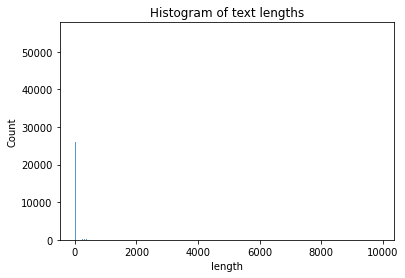

In [16]:
## Lets check the the distributions

sns.histplot(df_train['length'], bins='auto')
plt.title('Histogram of text lengths')
plt.show()


#### we see that majority of the text is between 0 and 2000. Since the maximum length of text the GPT model handles is 1024, let's see that distribution.

In [17]:
import numpy as np


array = np.arange(0, 2000, step=100)
print(array)


[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900]


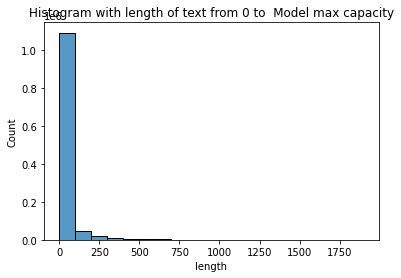

In [18]:
sns.histplot(df_train['length'], bins= array)
plt.title('Histogram with length of text from 0 to  Model max capacity')
plt.show()

In [19]:
# Let us check the number of rows whose length > 1024(the defualt length that the tokenizer can process)
exceed_tok_len = sum(df_train['length']> 1024)/len(df_train)*100
print(f"fewer than {exceed_tok_len}% of rows have text more than the length of model")

fewer than 0.11611397320133604% of rows have text more than the length of model


In [20]:
#Lets check for the number of rows where length is 0
sum(df_train['length'] == min_text_len)


13700

#### We notice that some of the rows in our dataframe have no text.
Removing such rows and resetting the indices 

In [21]:
df_train = df_train[df_train['length'].astype(bool)]

In [22]:
df_val = df_val[df_val['length'].astype(bool)]

In [23]:
sum(df_train['length'] == min_text_len)

0

In [24]:
sum(df_val['length'] == 0)

0

In [25]:
df_train.head()

,text,length
0,A:\tI'm sure they are.,21
1,"A:\tThat's right,",16
2,A:\tI'm sure that true.,22
3,A:\tIt's a lot different than working in a kid...,57
4,B:\tA lot different.,19


In [26]:
# resetting the index
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)


In [27]:
#calc the average len of the text:
mean_len = int(df_train.length.mean())
print(mean_len)
import math
power = math.ceil(math.log2(mean_len))
print(power)
context_length = 2**power
context_length
print(f"The context length is {context_length} ")

45
6
The context length is 64 


In [28]:
# Test the tokenizer:
#tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2", padding = True ,return_tensors = "pt" , truncate = True, max_length  = context_length ,return_overflowing_tokens=True)
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2",return_tensors = "pt" , truncate = True, max_length  = context_length ,return_overflowing_tokens=True , padding = False)

#tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained("distilgpt2")
#model = AutoModelForCausalLM.from_pretrained('./model/model2024-05-2923:30:09_.pth', from_flax=False)




tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [29]:
tokenizer.save_pretrained("./model")

('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/vocab.json',
 './model/merges.txt',
 './model/added_tokens.json',
 './model/tokenizer.json')

In [30]:
# Test code
#define a list of randomly generated text
# x = list(np.random.randint(0,60000,10))
# x
# text_list = [df_train.iloc[x]['text'] for x in x]
# text_list
# outputs = tokenizer(
#     text_list,
#     truncation=True,
#     max_length=context_length,
#     return_overflowing_tokens=True,
#     return_length=True,
#     padding = True
    
# )

# #print(f"Output: {outputs}")
# #print(f"Input IDs : {(outputs['input_ids'])}")
# print(f"Input IDs len : {(outputs['input_ids'])}")
# print(f"Input chunk lengths: {(outputs['length'])}")
# print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

### Data loaders and Dataset for batched training

In [30]:
# class dataset_pyt_old(Dataset):
#     def __init__(self, df, tokenizer, max_length = context_length ):
#         self.df = df
#         self.tokenizer = tokenizer
#         self.max_length = max_length
        
                        
#     def __getitem__(self, idx):
        
#         print(f"inside loader...idx ->{idx}")
#         text = self.df.iloc[idx]['text']
#         print(f"length of text ->{len(text)}")
#         print(f"text ->{text}")
#         #encoded = tokenizer(text, truncation=True, max_length=context_length, return_overflowing_tokens=True, padding = 'max_length')
#         encoded = tokenizer(text, truncation=True, max_length=context_length, return_overflowing_tokens=True, padding = False , return_tensors='pt')
#         input_ids = encoded['input_ids'].squeeze()
#         print(f"inside the loader and input_id = {input_ids} and its shape is {input_ids.shape}")
        
#         attention_mask = torch.tensor(encoded['attention_mask']).squeeze()
# #       print(f"inside the loader and input_id = {input_ids} and its shape is {input_ids.shape}")
#         labels = input_ids.clone()
#         print(f"inside the loader and input_id shape= {input_ids.shape} attention_mask_shape is {attention_mask.shape} and label shape is {labels.shape}")
#         return input_ids, attention_mask, labels
        
#     def __len__(self):
#         #return the length of the dataframe
#         return len(self.df)
    

In [31]:
class dataset_pyt(Dataset):
    def __init__(self, df, tokenizer, max_length = context_length ):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
                                
    def __getitem__(self, idx):
        #print(f"inside loader...idx ->{idx}")
        text = self.df.iloc[idx]['text']
        #print(f"length of text ->{len(text)}")
        #print(f"text ->{text}")
        #encodings = tokenizer(text, truncation=True, max_length= self.max_length, return_overflowing_tokens=True, padding = 'max_length',return_tensors='pt')
        encodings = tokenizer(text, truncation=True, max_length= self.max_length, return_overflowing_tokens=True, padding = False)
        # check the length of the encoded list
        
        #x_dict['input_id'] = input_ids_list
        #x_dict['attention_mask'] = input_ids_list
                
        #print(f"x_dict = {x_dict}")             
#       print(f"inside the loader and input_id = {input_ids} and its shape is {input_ids.shape}")
        #labels = input_id_list
        #input_ids = torch.tensor(input_id_list)
        #attention_mask = torch.tensor(attention_mask_list)
        #labels = torch.tensor(labels)
        #print(f"inside the loader and input_id shape= {input_ids.shape} attention_mask_shape is {attention_mask.shape} and label shape is {labels.shape}")
        #print(f"encoding = {encodings}")
               
        return encodings
        
    def __len__(self):
        #return the length of the dataframe
        return len(self.df)

In [32]:
def custom_collate_fn(batch, ):
    x_dict = {}
    #print("CUSTOM COllate")
    #print(f"bacth = {batch}")
    input_ids_list = []
    att_mask_list = [] 
    for elem,item in enumerate(batch):
        #print(f"element {elem}")
        #print(f"item = {item}")
        #check whether there are any nested lists :
        if len(item['input_ids']) > 1:
            #print(f"flattening the list")
            input_id_tensor = torch.tensor(list(itertools.chain(*item['input_ids'])))
            #print(f"shape of the flattended tensor = {input_id_tensor.shape}")
            input_ids_list.append(input_id_tensor[:1024])
            att_mask_tensor = torch.tensor(list(itertools.chain(*item['attention_mask'])))
            att_mask_list.append(att_mask_tensor[:1024])
        else:
            input_id_tensor = torch.tensor(item['input_ids']).squeeze(0)
            input_ids_list.append(input_id_tensor)
            att_mask_tensor = torch.tensor(item['attention_mask']).squeeze(0)
            #print(f"shape of att_mask_tensor tensor = {att_mask_tensor.shape}")
            att_mask_list.append(att_mask_tensor)
    #attention_mask = [item['attention_mask'].squeeze(0) for item in batch]

    # Pad sequences to the same length
    #print(f"len of input_id_list = {len(input_ids_list)}")
    #print(f"len of attmask_list = {len(att_mask_list)}")
    #input_id_tensor = torch.tensor(input_ids_list).squeeze()
    #att_mask_tensor = torch.tensor(att_mask_list).squeeze()
    #print("*********************")
    #print(f"input_ids_list = {input_ids_list}")
    
        
    
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids_list, batch_first=True, padding_value=tokenizer.eos_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(att_mask_list, batch_first=True, padding_value=0)
    #print(f"shape of input_id tensor post padding -{input_ids.shape}")
    #print(f"shape of attention_masks tensor post padding -{attention_mask.shape}")
    x_dict['input_ids'] = input_ids
    x_dict['attention_mask'] = attention_mask
    
    return x_dict

In [33]:
filtered_df = df_train[df_train['length']>2000]
len(filtered_df)

170

In [34]:
all_text = list(df_train['text'])
len(all_text)


1165314

In [35]:
#train_dataset = dataset_pyt(filtered_df,tokenizer = tokenizer)
train_dataset = dataset_pyt(df_train,tokenizer = tokenizer)
val_dataset = dataset_pyt(df_val,tokenizer = tokenizer)
#test_dataset = dataset_pyt(df_test,tokenizer = tokenizer)

train_loader = DataLoader(train_dataset,batch_size = batch_size, shuffle = True , num_workers = 4, pin_memory = True, collate_fn = custom_collate_fn)
val_loader = DataLoader(val_dataset,batch_size = batch_size, shuffle = True , collate_fn = custom_collate_fn)
#test_loader = DataLoader(test_dataset,batch_size = batch_size, shuffle = False, collate_fn = custom_collate_fn)

    

### Training the model

In [36]:
print(f"The length of train loader is {len(train_loader)}")

The length of train loader is 36417


In [37]:
#https://stackoverflow.com/questions/73948214/how-to-convert-a-pytorch-nn-module-into-a-huggingface-pretrainedmodel-object/74109727#74109727
# this code is needed to save the HF model as pre-trained and use this model as inference
# class MyConfig(PretrainedConfig):
#     model_type = 'mymodel'
#     def __init__(self, important_param=42, **kwargs):
#         super().__init__(**kwargs)
#         self.important_param = important_param

# class MyModel(PreTrainedModel):
#     config_class = MyConfig
#     def __init__(self, config):
#         super().__init__(config)
#         self.config = config
#         self.model = clf_model_drp()
#     def forward(self, ids ,token_type,att_mask):
#         return self.model(ids ,token_type,att_mask) 

In [38]:
# for ind , batch in enumerate(train_loader):
#     print(f"batch ind ={ind}")
#     print(batch['input_ids'].shape)


In [39]:
@torch.no_grad
def eval_model(val_loader, model, epoch , device = device,):
    global global_val_loss
    #m = nn.Softmax()
    model.eval()
    model.to(device)
    e = epoch+1
    val_loss_list = []
    #criterion = torch.nn.BCEWithLogitsLoss()
    print(f"inside validation data for epoch {e}")
    #y_hat_val_list = []
    #y_val_list = []
    
    for ind,x_dict  in enumerate(val_loader):
        id_list = x_dict['input_ids']
        #print(f"id_list{id_list}")
        ids = id_list.clone().detach().to(device = device)
        att_list = x_dict['attention_mask']
        att_mask = att_list.clone().detach().to(device= device)
        labels = ids.clone().detach().to(device = device)
        #predictions
        #print(f"input_ids device = {input_ids.device}")
        with autocast():
            model_output = model(input_ids = ids ,attention_mask = att_mask, labels = labels)
            act_loss = model_output.loss
        
        val_loss_list.append(act_loss)
                    
    mean_val_loss = torch.mean(torch.tensor(val_loss_list))
    if mean_val_loss < global_val_loss:
        print(f"Val loss has decreased -->reducing the global validation loss from {global_val_loss:.2f} to {mean_val_loss:.2f}")
        global_val_loss = mean_val_loss
        print(f" validation loss for epoch = {e} is {torch.mean(torch.tensor(val_loss_list)):.4f}")
        #print metrics and save the model
        #y_hat_val = torch.cat(y_hat_val_list)
        #y_val = torch.cat(y_val_list)
        #acc_val = accuracy_score(y_val.cpu().numpy(), y_hat_val.cpu().numpy())
        #f1_val = f1_score(y_val.cpu().numpy(), y_hat_val.cpu().numpy(), average='micro')
        print(f" epoch= {e} : mean val loss is {torch.mean(torch.tensor(mean_val_loss)):.4f} ")
        #save the model
        
        # Get the current date and time
        current_datetime = datetime.datetime.now()
        # Extract date and time components
        current_date = str(current_datetime.date())
        current_time = str(current_datetime.time()).split('.')[0]
        file_name = 'model'+ current_date+current_time+'_'+'.pth'
        path = os.path.join("model",file_name)
        print(f"saving the model {file_name}")
        #torch.save(model.state_dict(), path)
        model.save_pretrained(path)
        
        #plot_confusion_matrix(y_val.cpu().numpy(), y_hat_val.cpu().numpy(), labels)
    else:
        print(f"No improvement in validation loss-->epoch= {e} and global val loss is {global_val_loss:.2f}")
        
    
    
    
      

In [40]:
def train_model(train_loader,val_loader,model,num_epoch = 10,device = device):
    global global_tr_loss
    scaler = GradScaler()
    model.train()
    device = device
    print(f"inside train model. Device = {device}")
    optimizer = torch.optim.AdamW(params =  model.parameters(), lr= 5e-5)
    model.to(device)
    #m = nn.Softmax()
    import time
    epoch_start_time = time.time()
    from transformers import get_linear_schedule_with_warmup
    scheduler = transformers.get_cosine_schedule_with_warmup( optimizer= optimizer, num_warmup_steps =len(train_loader)*num_epoch*.1 ,num_training_steps= len(train_loader)*num_epoch,last_epoch = -1 )
    
    for i in range (num_epoch):
        #y_hat_list =[]
        #label_list = []
        epoch_train_loss = []
        for ind,x_dict in enumerate(train_loader):
            #print(f"x_dict = {x_dict}")
            id_list = x_dict['input_ids']
            #print(f"id_list{id_list}")
            if ind%10000 == 0:
                batch_time = time.time()
                duration = batch_time - epoch_start_time
                print(f"executing epoch:{i+1}, it took {duration/60} mins from beginning of epoch till batch#{ind}")
            
            
            ids = id_list.clone().detach().to(device = device)
            att_list = x_dict['attention_mask']
            att_mask = att_list.clone().detach().to(device= device)
            labels = ids.clone().detach().to(device = device)
            #predictions
            #print(f"shape of ids = {ids.shape} and shape of att_mask = {att_mask.shape}")
            
            with autocast():
                model_output = model(input_ids = ids ,attention_mask = att_mask, labels = labels)
                act_loss = model_output.loss
            
            #print(f"model_output->{model_output}")
            #probs = m(logits)
            #y_hat_list.append(torch.argmax(probs , dim = 1))
            #label_list.append(torch.argmax(lab, dim = 1))
            
            #loss calculation                   
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(act_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_train_loss.append(act_loss)
            #print(f"current LR->{scheduler.get_last_lr()}")
            scheduler.step()
            del id_list,ids,att_list,att_mask,labels
            
        #batch processing complete    
        mean_loss = torch.mean(torch.tensor(epoch_train_loss))
        
        if mean_loss < global_tr_loss:
            print(f"training loss has decreased---> reducing the global loss from {global_tr_loss:.2f} to {mean_loss:.2f}")
            global_tr_loss = mean_loss
            print(f" epoch= {i+1} and mean train loss is {torch.mean(torch.tensor(epoch_train_loss)):.2f}")
            #printing training metrices
            #y_hat = torch.cat(y_hat_list)
            #y = torch.cat(label_list)
            #acc = accuracy_score(y.cpu().numpy(), y_hat.cpu().numpy())
            #f1 = f1_score(y.cpu().numpy(), y_hat.cpu().numpy(), average='micro')
            print(f" epoch= {i+1} : mean train loss is {torch.mean(torch.tensor(epoch_train_loss)):.4f} ")
            #checking validation metrices
            eval_model(val_loader, model, epoch = i , device = device)
            
        else:
            print(f"No improvement in training loss..the global training loss is -->{global_tr_loss:.2f} ")
            print(f" epoch= {i+1} and mean train loss is {torch.mean(torch.tensor(epoch_train_loss)):.2f}")
        
        
    
    return model
        
            
            
    
    

In [41]:
# config = MyConfig(42)
# model = MyModel(config)

#train_loader,optimizer,val_loader ,num_epoch = 100, model = clf_model()
tr_model = train_model(train_loader, val_loader, model =  model)

inside train model. Device = cuda:0
executing epoch:1, it took 0.0028143723805745444 mins from beginning of epoch till batch#0
executing epoch:1, it took 6.751577790578207 mins from beginning of epoch till batch#10000
executing epoch:1, it took 13.414709762732189 mins from beginning of epoch till batch#20000
executing epoch:1, it took 20.118542404969535 mins from beginning of epoch till batch#30000
training loss has decreased---> reducing the global loss from inf to 0.77
 epoch= 1 and mean train loss is 0.77
 epoch= 1 : mean train loss is 0.7665 
inside validation data for epoch 1
Val loss has decreased -->reducing the global validation loss from inf to 0.65
 validation loss for epoch = 1 is 0.6494
 epoch= 1 : mean val loss is 0.6494 
saving the model model2024-05-2922:55:57_.pth


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

executing epoch:2, it took 33.867545727888746 mins from beginning of epoch till batch#0
executing epoch:2, it took 40.51047882239024 mins from beginning of epoch till batch#10000
executing epoch:2, it took 47.1551540851593 mins from beginning of epoch till batch#20000
executing epoch:2, it took 53.853352069854736 mins from beginning of epoch till batch#30000
training loss has decreased---> reducing the global loss from 0.77 to 0.60
 epoch= 2 and mean train loss is 0.60
 epoch= 2 : mean train loss is 0.6044 
inside validation data for epoch 2
Val loss has decreased -->reducing the global validation loss from 0.65 to 0.64
 validation loss for epoch = 2 is 0.6427
 epoch= 2 : mean val loss is 0.6427 
saving the model model2024-05-2923:30:09_.pth


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

executing epoch:3, it took 68.10993497371673 mins from beginning of epoch till batch#0
executing epoch:3, it took 74.75176033178965 mins from beginning of epoch till batch#10000
executing epoch:3, it took 81.40756795008977 mins from beginning of epoch till batch#20000
executing epoch:3, it took 88.12616647879283 mins from beginning of epoch till batch#30000
training loss has decreased---> reducing the global loss from 0.60 to 0.58
 epoch= 3 and mean train loss is 0.58
 epoch= 3 : mean train loss is 0.5785 
inside validation data for epoch 3
No improvement in validation loss-->epoch= 3 and global val loss is 0.64


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

executing epoch:4, it took 102.29235746860505 mins from beginning of epoch till batch#0
executing epoch:4, it took 108.97194888989131 mins from beginning of epoch till batch#10000
executing epoch:4, it took 115.68814454476039 mins from beginning of epoch till batch#20000
executing epoch:4, it took 122.3911456545194 mins from beginning of epoch till batch#30000
training loss has decreased---> reducing the global loss from 0.58 to 0.55
 epoch= 4 and mean train loss is 0.55
 epoch= 4 : mean train loss is 0.5546 
inside validation data for epoch 4
No improvement in validation loss-->epoch= 4 and global val loss is 0.64


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

executing epoch:5, it took 136.59514906803767 mins from beginning of epoch till batch#0
executing epoch:5, it took 143.27317264080048 mins from beginning of epoch till batch#10000
executing epoch:5, it took 149.99504707256952 mins from beginning of epoch till batch#20000
executing epoch:5, it took 156.67467699050903 mins from beginning of epoch till batch#30000
training loss has decreased---> reducing the global loss from 0.55 to 0.54
 epoch= 5 and mean train loss is 0.54
 epoch= 5 : mean train loss is 0.5356 
inside validation data for epoch 5
No improvement in validation loss-->epoch= 5 and global val loss is 0.64


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

executing epoch:6, it took 170.91215680440266 mins from beginning of epoch till batch#0
executing epoch:6, it took 177.62393314441044 mins from beginning of epoch till batch#10000
executing epoch:6, it took 184.3071643948555 mins from beginning of epoch till batch#20000
executing epoch:6, it took 190.91964925527571 mins from beginning of epoch till batch#30000
training loss has decreased---> reducing the global loss from 0.54 to 0.52
 epoch= 6 and mean train loss is 0.52
 epoch= 6 : mean train loss is 0.5164 
inside validation data for epoch 6
No improvement in validation loss-->epoch= 6 and global val loss is 0.64


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

executing epoch:7, it took 205.0955301562945 mins from beginning of epoch till batch#0
executing epoch:7, it took 211.7667381922404 mins from beginning of epoch till batch#10000
executing epoch:7, it took 218.44795283873876 mins from beginning of epoch till batch#20000
executing epoch:7, it took 225.14807022412617 mins from beginning of epoch till batch#30000
training loss has decreased---> reducing the global loss from 0.52 to 0.50
 epoch= 7 and mean train loss is 0.50
 epoch= 7 : mean train loss is 0.4993 
inside validation data for epoch 7
No improvement in validation loss-->epoch= 7 and global val loss is 0.64


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

executing epoch:8, it took 239.36520983775458 mins from beginning of epoch till batch#0
executing epoch:8, it took 246.0550956606865 mins from beginning of epoch till batch#10000
executing epoch:8, it took 252.6642674724261 mins from beginning of epoch till batch#20000
executing epoch:8, it took 259.3894014596939 mins from beginning of epoch till batch#30000


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


training loss has decreased---> reducing the global loss from 0.50 to 0.48
 epoch= 8 and mean train loss is 0.48
 epoch= 8 : mean train loss is 0.4842 
inside validation data for epoch 8
No improvement in validation loss-->epoch= 8 and global val loss is 0.64


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

executing epoch:9, it took 273.5850135445595 mins from beginning of epoch till batch#0
executing epoch:9, it took 280.2811160683632 mins from beginning of epoch till batch#10000
executing epoch:9, it took 286.92080185413363 mins from beginning of epoch till batch#20000
executing epoch:9, it took 293.5819669405619 mins from beginning of epoch till batch#30000
training loss has decreased---> reducing the global loss from 0.48 to 0.47
 epoch= 9 and mean train loss is 0.47
 epoch= 9 : mean train loss is 0.4723 
inside validation data for epoch 9
No improvement in validation loss-->epoch= 9 and global val loss is 0.64


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

executing epoch:10, it took 307.82337380250294 mins from beginning of epoch till batch#0
executing epoch:10, it took 314.5148380359014 mins from beginning of epoch till batch#10000
executing epoch:10, it took 321.20669003327686 mins from beginning of epoch till batch#20000
executing epoch:10, it took 327.88360801140465 mins from beginning of epoch till batch#30000
training loss has decreased---> reducing the global loss from 0.47 to 0.47
 epoch= 10 and mean train loss is 0.47
 epoch= 10 : mean train loss is 0.4651 
inside validation data for epoch 10
No improvement in validation loss-->epoch= 10 and global val loss is 0.64


### Evaluating the models on test data

In [42]:
def tokenize(element):
    outputs = tokenizer(
        element["content"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}


tokenized_datasets = raw_datasets.map(
    tokenize, batched=True, remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets

NameError: name 'raw_datasets' is not defined

In [ ]:
t = df_train.iloc[400327]['text']
print (t)
print(len(t))
encoded = tokenizer(t, truncation=True, max_length=context_length, return_overflowing_tokens=True, padding = 'max_length',return_length= True)
print(encoded)
input_ids = torch.tensor(encoded['input_ids'])
print(f"inside the loader and input_id = {input_ids} and its shape is {input_ids.shape}")

attention_mask = torch.tensor(encoded['attention_mask'])
#       print(f"inside the loader and input_id = {input_ids} and its shape is {input_ids.shape}")
labels = input_ids.clone()
print(f"inside the loader and input_id shape= {input_ids.shape} attention_mask_shape is {attention_mask.shape} and label shape is {labels.shape}")


In [ ]:
def final_pred(loader, model, device = device,):
    m = nn.Softmax()
    model.eval()
    model.to(device)
    test_loss_list = []
    criterion = torch.nn.BCEWithLogitsLoss()
    y_hat_test_list = []
    y_test_list = []
    for ind,(x_dict, label_vec) in enumerate(loader):
        model.to(device)
        id_list = x_dict['id']
        ids = torch.squeeze(torch.tensor(id_list, device = device),dim = 1).clone().detach()
        tok_type_list = x_dict['token_type']
        token_type = torch.squeeze(torch.tensor(tok_type_list, device = device),dim = 1).clone().detach()
        att_list = x_dict['attention_mask']
        att_mask = torch.squeeze(torch.tensor(att_list, device = device),dim = 1).clone().detach()
        lab = label_vec.to(torch.device('cuda:0'))
        logits = model(ids ,token_type,att_mask)
        
        probs = m(logits)
        y_hat_test_list.append(torch.argmax(probs , dim = 1))
        y_test_list.append(torch.argmax(lab , dim = 1))
        
        act_loss = criterion(logits, lab)
        test_loss_list.append(act_loss.item())
            
    mean_test_loss = torch.mean(torch.tensor(test_loss_list))
    print(f" Test loss is {torch.mean(torch.tensor(test_loss_list)):.4f}")
    #print metrics and save the model
    y_hat_test = torch.cat(y_hat_test_list)
    y_test = torch.cat(y_test_list)
    acc_test = accuracy_score(y_test.cpu().numpy(), y_hat_test.cpu().numpy())
    f1_test = f1_score(y_test.cpu().numpy(), y_hat_test.cpu().numpy(), average='micro')
    print(f"mean loss is {torch.mean(torch.tensor(mean_test_loss)):.4f} -> the accuracy is {acc_test:.2f} ->the f1 is {f1_test:.2f} ")
    #save the model
    plot_confusion_matrix(y_test.cpu().numpy(), y_hat_test.cpu().numpy(), labels)

   
        


In [ ]:
saved_model = MyModel.from_pretrained('./model/model2024-05-1712:14:28_mrpc.pth')


In [ ]:
final_pred(test_loader , saved_model )

In [4]:
model_new = AutoModelForCausalLM.from_pretrained('./model/model2024-05-2923:30:09_.pth', from_flax=False)

In [5]:
model_new.save_pretrained('./model', safe_serialization=False)